# Boston House Prices

**Data Set Characteristics:**

*Number of Instances:*

506

*Number of Attributes:*

13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

*Attribute Information (in order):*

*   CRIM per capita crime rate by town
*   ZN proportion of residential land zoned for lots over 25,000 sq.ft.
*   INDUS proportion of non-retail business acres per town
*   CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
*   NOX nitric oxides concentration (parts per 10 million)
*   RM average number of rooms per dwelling
*   AGE proportion of owner-occupied units built prior to 1940
*   DIS weighted distances to five Boston employment centres
*   RAD index of accessibility to radial highways
*   TAX full-value property-tax rate per 10,000 dollars
*   PTRATIO pupil-teacher ratio by town
*   B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
*   LSTAT % lower status of the population
*   MEDV Median value of owner-occupied homes in 1,000 dollars’s

*Missing Attribute Values:*
 	
None

*Creator:*

Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset. https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. ‘Hedonic prices and the demand for clean air’, J. Environ. Economics & Management, vol.5, 81-102, 1978. Used in Belsley, Kuh & Welsch, ‘Regression diagnostics …’, Wiley, 1980. N.B. Various transformations are used in the table on pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression problems.

*References:*

Belsley, Kuh & Welsch, ‘Regression diagnostics: Identifying Influential Data and Sources of Collinearity’, Wiley, 1980. 244-261.
Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
6.2.2. Iris plants dataset

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn import datasets, ensemble, linear_model
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [85]:
# Load data

boston = datasets.load_boston()
X, y = boston.data, boston.target
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1)
print(X_train.shape, X_test.shape)

(455, 13) (51, 13)


In [86]:
# Fit GBM regression model

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
y_pred_G = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_G)
print("MSE: %.4f" % mse)
print('Variance score: %.2f' % r2_score(y_test, y_pred_G))

MSE: 7.2769
Variance score: 0.93


Text(0, 0.5, 'Deviance')

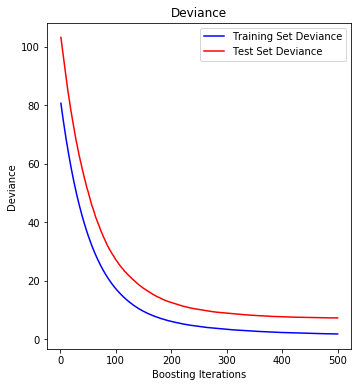

In [87]:
# Compute test set deviance

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred_G in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred_G)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

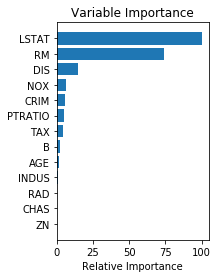

In [88]:
# Plot feature importance

feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [89]:
# Fit XGBoost model

paramsxgb = {'max_depth': 3, 'eta': 0.01}
xgboost = xgb.XGBRegressor(**paramsxgb)
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
print("MSE: %.4f" % mse)
print('Variance score: %.2f' % r2_score(y_test, y_pred_xgb))

[07:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 7.9124
Variance score: 0.92


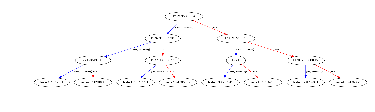

In [90]:
# Plot XGBoost decision tree

xgb.plot_tree(xgboost)
plt.show()

In [91]:
# Fit linear model

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred_L = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_L)
print("MSE: %.4f" % mse)
print(reg.coef_)
print('Variance score: %.2f' % r2_score(y_test, y_pred_L))

MSE: 24.2293
[-1.1019252e-01  4.9098622e-02  3.8963482e-02  1.7659584e+00
 -1.7960857e+01  3.6346409e+00 -6.6016242e-04 -1.4776672e+00
  2.9905599e-01 -1.2902200e-02 -9.4185263e-01  8.5173417e-03
 -5.2699482e-01]
Variance score: 0.77


In [0]:
# Apply polynomial transformation

poly = PolynomialFeatures(degree=2)
X_train_t = poly.fit_transform(X_train)
X_test_t = poly.fit_transform(X_test)

In [93]:
# Fit GLM model

glm = linear_model.LinearRegression()
glm.fit(X_train_t, y_train)
y_pred_t = glm.predict(X_test_t)
mse = mean_squared_error(y_test, y_pred_t)
print("MSE: %.4f" % mse)
print(reg.coef_)
print('Variance score: %.2f' % r2_score(y_test, y_pred_t))

MSE: 18.5665
[-1.1019252e-01  4.9098622e-02  3.8963482e-02  1.7659584e+00
 -1.7960857e+01  3.6346409e+00 -6.6016242e-04 -1.4776672e+00
  2.9905599e-01 -1.2902200e-02 -9.4185263e-01  8.5173417e-03
 -5.2699482e-01]
Variance score: 0.82


In [94]:
# Fit Ridge regularisation L2 model

rid = linear_model.Ridge(alpha=.5)
rid.fit(X_train_t, y_train)
y_pred_r = rid.predict(X_test_t)
mse = mean_squared_error(y_test, y_pred_r)
print("MSE: %.4f" % mse)
print(reg.coef_)
print('Variance score: %.2f' % r2_score(y_test, y_pred_r))

MSE: 7.5701
[-1.1019252e-01  4.9098622e-02  3.8963482e-02  1.7659584e+00
 -1.7960857e+01  3.6346409e+00 -6.6016242e-04 -1.4776672e+00
  2.9905599e-01 -1.2902200e-02 -9.4185263e-01  8.5173417e-03
 -5.2699482e-01]
Variance score: 0.93


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.1879e-14): result may not be accurate.
  overwrite_a=True).T


In [95]:
# Fit Lasso regularisation L1 model

las = linear_model.Lasso(alpha=0.5)
las.fit(X_train_t, y_train)
y_pred_ls = las.predict(X_test_t)
mse = mean_squared_error(y_test, y_pred_ls)
print("MSE: %.4f" % mse)
print(reg.coef_)
print('Variance score: %.2f' % r2_score(y_test, y_pred_ls))

MSE: 14.1980
[-1.1019252e-01  4.9098622e-02  3.8963482e-02  1.7659584e+00
 -1.7960857e+01  3.6346409e+00 -6.6016242e-04 -1.4776672e+00
  2.9905599e-01 -1.2902200e-02 -9.4185263e-01  8.5173417e-03
 -5.2699482e-01]
Variance score: 0.86


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372.994873046875, tolerance: 3.736489772796631
  positive)


In [96]:
# Fit ElasticNet L1 + L2 model

ela = ElasticNet(alpha=.5)
ela.fit(X_train_t, y_train)
y_pred_e = ela.predict(X_test_t)
mse = mean_squared_error(y_test, y_pred_e)
print("MSE: %.4f" % mse)
print(reg.coef_)
print('Variance score: %.2f' % r2_score(y_test, y_pred_e))

MSE: 13.9382
[-1.1019252e-01  4.9098622e-02  3.8963482e-02  1.7659584e+00
 -1.7960857e+01  3.6346409e+00 -6.6016242e-04 -1.4776672e+00
  2.9905599e-01 -1.2902200e-02 -9.4185263e-01  8.5173417e-03
 -5.2699482e-01]
Variance score: 0.87


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2241.30908203125, tolerance: 3.736489772796631
  positive)
